In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
%cd /content/drive/MyDrive/GitHub/{repo}

/content/drive/MyDrive/GitHub/reportingAgent


In [5]:
import seaborn as sns
import pandas as pd
import numpy as np

In [8]:
pm = "C"
TOP_K_PARAM = 5 # CHOOSE BETWEEN THE TOP K
TOP_SCORE = "ce_sim"

def get_top_params_by_stat(df,
                           prompt_method:str,
                           stat: str, # "min", "25%", "50%", "75%", "max", "std"
                           top_k_param: int = TOP_K_PARAM,
                           top_score:str = TOP_SCORE,
                           ):
  """
  prompt_method : A B or C
  stat: the statistic used for the sorting strategy,
        e.g if stat="mean" is given, we are going to sort the best mean values.
  top_k_param: Return the best top K values. e.g if top_k_param = 1 will return the best parameter for the give stat.
  top_score: The metric that we are going to target for sorting the best parameters
  """

  df_ord_X = df[df.prompt_method == prompt_method]
  # TODO: Change to new cf.METRICS.X_KEY values
  col_nb_pm = df_ord_X.columns.get_loc("prompt_method")
  col_nb_bs = df_ord_X.columns.get_loc("bs_precision")
  col_nb_ce = df_ord_X.columns.get_loc("title")
  param_col_names = df_ord_X.columns[col_nb_pm+1:col_nb_bs].to_numpy()  # list with the keys of the parameters
  scores_col_names = df_ord_X.columns[col_nb_bs:col_nb_ce].to_numpy()  # list with the keys of the scores
  print(f"The parameters in this results data set are: {param_col_names}")
  print(f"The scores in this results data set are: {scores_col_names}")
  df_scores = df_ord_X[np.append(param_col_names, scores_col_names)]
  df_param_scores_stats = df_scores.groupby(param_col_names.tolist()).describe()

  # filter the TOP_K stats according to the given stat and top_score
  top_params = df_param_scores_stats.sort_values(by=(top_score,stat), ascending=False)[top_score].head(top_k_param)
  top_params.columns.name = "*" + top_score + " ordered by best *" + stat
  return top_params

In [9]:
doc_1 = "tb-microsoft-phi-2-14-082025 13-26-26"
doc_2 = "tb-HuggingFaceTB-SmolLM3-3B-14-082025 21-43-55"
doc_3 = "tb-openai-community-gpt2-xl-14-082025 18-59-44"
doc_4 = "tb-microsoft-phi-2-14-082025 16-24-58"
doc_5 = "tb-microsoft-phi-2-14-082025 13-26-26" # first test 5 reports.

phi_2_80_first = "tb-microsoft-phi-2-16-082025 02-50-43" # first 80 reports on phi-2
# --temperature 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 30 50 70 --max_new_tokens 300 --do_sample True

DOC = phi_2_80_first
df = pd.read_excel("app/results/test-bench/" + DOC + ".xlsx")

In [10]:
# Select by best 3 mean value
get_top_params_by_stat(df,
                       prompt_method = "C",
                       stat="mean", # "min", "25%", "50%", "75%", "max", "std"
                       top_k_param = 5,
                       top_score = "ce_sim",
                        )


The parameters in this results data set are: ['temperature' 'top_p' 'top_k' 'max_new_tokens' 'do_sample'
 'repetition_penalty']
The scores in this results data set are: ['bs_precision' 'bs_recall' 'bs_f1' 'be_sim' 'ce_sim']


*ce_sim ordered by best *mean                                        count  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty          
1.0         0.3   70    300            True      1                    80.0   
0.7         0.3   50    300            True      1                    80.0   
1.0         0.3   50    300            True      1                    80.0   
                  30    300            True      1                    80.0   
0.7         0.3   30    300            True      1                    80.0   

*ce_sim ordered by best *mean                                            mean  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.870190   
0.7         0.3   50    300            True      1                   0.868681   
1.0         0.3   50    300            True      1                   0.867615   
                  30    300            True      1                   0.867026   
0.7         0.3   30    300            True      1                   0.866216   

*ce_sim ordered by best *mean                                             std  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.067727   
0.7         0.3   50    300            True      1                   0.067839   
1.0         0.3   50    300            True      1                   0.067570   
                  30    300            True      1                   0.068212   
0.7         0.3   30    300            True      1                   0.068336   

*ce_sim ordered by best *mean                                             min  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.681175   
0.7         0.3   50    300            True      1                   0.676318   
1.0         0.3   50    300            True      1                   0.686895   
                  30    300            True      1                   0.686919   
0.7         0.3   30    300            True      1                   0.650189   

*ce_sim ordered by best *mean                                             25%  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.820511   
0.7         0.3   50    300            True      1                   0.816756   
1.0         0.3   50    300            True      1                   0.816756   
                  30    300            True      1                   0.819152   
0.7         0.3   30    300            True      1                   0.816756   

*ce_sim ordered by best *mean                                             50%  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.876079   
0.7         0.3   50    300            True      1                   0.872622   
1.0         0.3   50    300            True      1                   0.871829   
                  30    300            True      1                   0.871829   
0.7         0.3   30    300            True      1                   0.871502   

*ce_sim ordered by best *mean                                             75%  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.910731   
0.7         0.3   50    300            True      1                   0.914990   
1.0         0.3   50    300            True      1                   0.913892   
                  30    300            True      1                   0.913892   
0.7         0.3   30    300            True      1                   0.913590   

*ce_sim ordered by best *mean                

In [11]:
# Select by best 5 median values
get_top_params_by_stat(df,
                       prompt_method = "C",
                       stat="50%", # "min", "25%", "50%", "75%", "max", "std"
                       top_k_param = 5,
                       top_score = "ce_sim",
                        )

The parameters in this results data set are: ['temperature' 'top_p' 'top_k' 'max_new_tokens' 'do_sample'
 'repetition_penalty']
The scores in this results data set are: ['bs_precision' 'bs_recall' 'bs_f1' 'be_sim' 'ce_sim']


*ce_sim ordered by best *50%                                         count  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty          
1.0         0.3   70    300            True      1                    80.0   
0.7         0.3   50    300            True      1                    80.0   
            0.9   30    300            True      1                    80.0   
1.0         0.3   30    300            True      1                    80.0   
                  50    300            True      1                    80.0   

*ce_sim ordered by best *50%                                             mean  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.870190   
0.7         0.3   50    300            True      1                   0.868681   
            0.9   30    300            True      1                   0.857566   
1.0         0.3   30    300            True      1                   0.867026   
                  50    300            True      1                   0.867615   

*ce_sim ordered by best *50%                                              std  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.067727   
0.7         0.3   50    300            True      1                   0.067839   
            0.9   30    300            True      1                   0.076220   
1.0         0.3   30    300            True      1                   0.068212   
                  50    300            True      1                   0.067570   

*ce_sim ordered by best *50%                                              min  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.681175   
0.7         0.3   50    300            True      1                   0.676318   
            0.9   30    300            True      1                   0.627148   
1.0         0.3   30    300            True      1                   0.686919   
                  50    300            True      1                   0.686895   

*ce_sim ordered by best *50%                                              25%  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.820511   
0.7         0.3   50    300            True      1                   0.816756   
            0.9   30    300            True      1                   0.811828   
1.0         0.3   30    300            True      1                   0.819152   
                  50    300            True      1                   0.816756   

*ce_sim ordered by best *50%                                              50%  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.876079   
0.7         0.3   50    300            True      1                   0.872622   
            0.9   30    300            True      1                   0.872545   
1.0         0.3   30    300            True      1                   0.871829   
                  50    300            True      1                   0.871829   

*ce_sim ordered by best *50%                                              75%  \
temperature top_p top_k max_new_tokens do_sample repetition_penalty             
1.0         0.3   70    300            True      1                   0.910731   
0.7         0.3   50    300            True      1                   0.914990   
            0.9   30    300            True      1                   0.906480   
1.0         0.3   30    300            True      1                   0.913892   
                  50    300            True      1                   0.913892   

*ce_sim ordered by best *50%                 

In [48]:
pm = "C"
TOP_K = 5
TOP_SCORE = "ce_sim"
# TODO: Change to new cf.METRICS.X_KEY values
df_ord_X = df[df.prompt_method == pm]
col_nb_pm = df_ord_X.columns.get_loc("prompt_method")
col_nb_bs = df_ord_X.columns.get_loc("bs_precision")
col_nb_ce = df_ord_X.columns.get_loc("title")
param_col_names = df_ord_X.columns[col_nb_pm+1:col_nb_bs].to_numpy()  # list with the keys of the parameters
scores_col_names = df_ord_X.columns[col_nb_bs:col_nb_ce].to_numpy()  # list with the keys of the scores
print(param_col_names)
print(scores_col_names)
df_scores = df_ord_X[np.append(param_col_names, scores_col_names)]
df_param_scores_mean = df_scores.groupby(param_col_names.tolist()).mean()
df_param_scores_stats = df_scores.groupby(param_col_names.tolist()).describe()



# Select the best parameters according to a TOP_SCORE
top_params = df_param_scores_mean.sort_values(by=TOP_SCORE, ascending=False).head(TOP_K)
top_params

['temperature' 'top_k' 'top_p' 'repetition_penalty' 'do_sample'
 'max_new_tokens']
['bs_precision' 'bs_recall' 'bs_f1' 'be_sim' 'ce_sim']


bs_precision  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens                 
0.7         30    0.8   1                  True      300                 0.916546   
2.0         10    0.5   1                  True      300                 0.913534   
1.3         50    0.2   1                  True      300                 0.918191   
0.3         50    0.5   1                  True      300                 0.921563   
            30    0.5   1                  True      300                 0.922027   

                                                                     bs_recall  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens              
0.7         30    0.8   1                  True      300              0.924447   
2.0         10    0.5   1                  True      300              0.920093   
1.3         50    0.2   1                  True      300              0.922719   
0.3         50    0.5   1                  True      300              0.922621   
            30    0.5   1                  True      300              0.921937   

                                                                        bs_f1  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.920307   
2.0         10    0.5   1                  True      300             0.916689   
1.3         50    0.2   1                  True      300             0.920257   
0.3         50    0.5   1                  True      300             0.921953   
            30    0.5   1                  True      300             0.921821   

                                                                       be_sim  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.896706   
2.0         10    0.5   1                  True      300             0.880875   
1.3         50    0.2   1                  True      300             0.875501   
0.3         50    0.5   1                  True      300             0.875543   
            30    0.5   1                  True      300             0.874294   

                                                                       ce_sim  
temperature top_k top_p repetition_penalty do_sample max_new_tokens            
0.7         30    0.8   1                  True      300             0.875428  
2.0         10    0.5   1                  True      300             0.868946  
1.3         50    0.2   1                  True      300             0.868717  
0.3         50    0.5   1                  True      300             0.867093  
            30    0.5   1                  True      300             0.866204

In [93]:
dff = df_param_scores_stats.sort_values(by=("ce_sim","mean"), ascending=False).head(TOP_K)["ce_sim"]

dff

test                                                                 count  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens          
0.7         30    0.8   1                  True      300              30.0   
2.0         10    0.5   1                  True      300              30.0   
1.3         50    0.2   1                  True      300              30.0   
0.3         50    0.5   1                  True      300              30.0   
            30    0.5   1                  True      300              30.0   

test                                                                     mean  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.875428   
2.0         10    0.5   1                  True      300             0.868946   
1.3         50    0.2   1                  True      300             0.868717   
0.3         50    0.5   1                  True      300             0.867093   
            30    0.5   1                  True      300             0.866204   

test                                                                      std  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.064223   
2.0         10    0.5   1                  True      300             0.070825   
1.3         50    0.2   1                  True      300             0.057223   
0.3         50    0.5   1                  True      300             0.058220   
            30    0.5   1                  True      300             0.062525   

test                                                                      min  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.771817   
2.0         10    0.5   1                  True      300             0.630560   
1.3         50    0.2   1                  True      300             0.775918   
0.3         50    0.5   1                  True      300             0.775918   
            30    0.5   1                  True      300             0.728467   

test                                                                      25%  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.824765   
2.0         10    0.5   1                  True      300             0.840509   
1.3         50    0.2   1                  True      300             0.816707   
0.3         50    0.5   1                  True      300             0.817497   
            30    0.5   1                  True      300             0.817158   

test                                                                      50%  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.878147   
2.0         10    0.5   1                  True      300             0.874806   
1.3         50    0.2   1                  True      300             0.875448   
0.3         50    0.5   1                  True      300             0.862233   
            30    0.5   1                  True      300             0.862233   

test                                                                      75%  \
temperature top_k top_p repetition_penalty do_sample max_new_tokens             
0.7         30    0.8   1                  True      300             0.914874   
2.0         10    0.5   1                  True      300             0.903593   
1.3         50    0.2   1                  True      300             0.908144   
0.3         50    0.5   1                  True      300             0.906171   
            30    0.5   1                  True      300             0.908677   

test                                         

In [108]:
import time

time.sleep(10)

In [ ]:
time.sleep(10)

In [110]:
time.sleep(10)

In [341]:
import seaborn as sns
import pandas as pd
import json

TOP_SCORE = "ce_sim"

df = pd.read_excel("app/results/test-bench/tb-microsoft-phi-2-14-082025 13-26-26.xlsx")
df_ord_C = df[df.prompt_method == "C"].sort_values(by=TOP_SCORE, ascending=False)
TOP_K = 3 # best K parameters to catch on "ce" (1st, 2nd, 3rd, ...)
SUM_TOP_K = 3  # Best params to select when doing the sum (heatmap)

In [362]:
def get_top_k_in_row(df_row, top_k = TOP_K):
  col_nb_pm = df_row.columns.get_loc("prompt_method")
  col_nb_bs = df_row.columns.get_loc("bs_precision")
  param_k = {}
  scores_k = {}
  for i in range(0, top_k):
    # json.dumps converts dict to str
    param_dict_i = df_row.iloc[i][col_nb_pm+1:col_nb_bs].to_dict()
    # param_dict_i.update({TOP_SCORE: round(df_row.iloc[i][TOP_SCORE],3)})
    param_k.update({str(i+1): json.dumps(param_dict_i)})
    # scores_k.update({str(i+1): round(df_row.iloc[i][TOP_SCORE],3)})
  return param_k


In [363]:
df_res = pd.DataFrame({})

for report_idx in df_ord_C.report_idx.sort_values().unique():
  top_k_report = df_ord_C[df_ord_C.report_idx == report_idx].head(TOP_K)
  top_dict = get_top_k_in_row(top_k_report)
  df_res = pd.concat([df_res, pd.DataFrame([top_dict], columns=["1","2","3"], index=[report_idx])])

# df_res.columns = ["params", "scores"]
# df_res.agg({0:"value_counts", 1: "mean"})
df_res.head()

,1,2,3
1,"{""temperature"": 1.3, ""top_k"": 10, ""top_p"": 1.0...","{""temperature"": 1.3, ""top_k"": 50, ""top_p"": 0.8...","{""temperature"": 2.0, ""top_k"": 30, ""top_p"": 0.5..."
2,"{""temperature"": 0.7, ""top_k"": 50, ""top_p"": 1.0...","{""temperature"": 1.3, ""top_k"": 30, ""top_p"": 0.5...","{""temperature"": 0.3, ""top_k"": 30, ""top_p"": 1.0..."
3,"{""temperature"": 2.0, ""top_k"": 50, ""top_p"": 0.5...","{""temperature"": 0.7, ""top_k"": 30, ""top_p"": 1.0...","{""temperature"": 0.7, ""top_k"": 50, ""top_p"": 0.5..."
4,"{""temperature"": 0.7, ""top_k"": 30, ""top_p"": 0.8...","{""temperature"": 1.3, ""top_k"": 30, ""top_p"": 0.2...","{""temperature"": 0.7, ""top_k"": 30, ""top_p"": 0.5..."
5,"{""temperature"": 2.0, ""top_k"": 10, ""top_p"": 0.5...","{""temperature"": 2.0, ""top_k"": 50, ""top_p"": 0.2...","{""temperature"": 0.7, ""top_k"": 30, ""top_p"": 1.0..."


,totals
method-C,
"{""temperature"": 0.7, ""top_k"": 10, ""top_p"": 1.0, ""repetition_penalty"": 1, ""do_sample"": true, ""max_new_tokens"": 300}",8.0
"{""temperature"": 0.7, ""top_k"": 30, ""top_p"": 1.0, ""repetition_penalty"": 1, ""do_sample"": true, ""max_new_tokens"": 300}",7.0
"{""temperature"": 2.0, ""top_k"": 10, ""top_p"": 0.5, ""repetition_penalty"": 1, ""do_sample"": true, ""max_new_tokens"": 300}",6.0


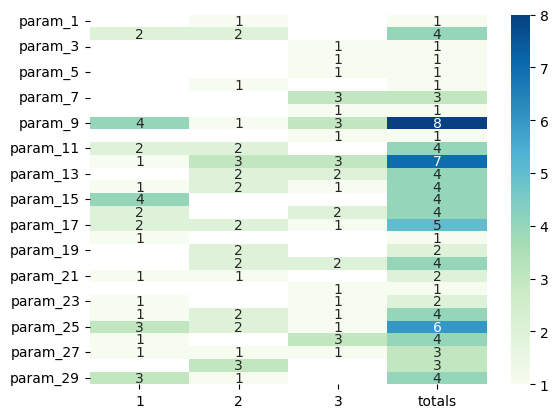

In [364]:
counts = df_res.apply(pd.Series.value_counts)
counts["totals"] = counts.sum(axis=1)

heat_map = counts.copy()
df_param_list = counts.index.to_list()
param_dict_converter =  {"param_" + str(i+1) : df_param_list[i]  for i in range(0, len(df_param_list))}
heat_map.index = param_dict_converter.keys()
sns.heatmap(heat_map, cmap="GnBu", annot=True)

top_param = counts.sort_values(by="totals", ascending=False)
top_params = top_param.totals.head(SUM_TOP_K)
top_params.index.name = "method-C"
top_params

In [345]:
param_dict_converter["param_9"]

'{"temperature": 0.3, "top_k": 50, "top_p": 0.5, "repetition_penalty": 1, "do_sample": true, "max_new_tokens": 300, "ce_sim": 0.838}'

         1        2        3
0  param_1  param_2  param_3
1  param_1  param_4  param_5
2  param_2  param_1  param_5
           1    2    3
param_1  2.0  1.0  NaN
param_2  1.0  1.0  NaN
param_3  NaN  NaN  1.0
param_4  NaN  1.0  NaN
param_5  NaN  NaN  2.0


<Axes: >

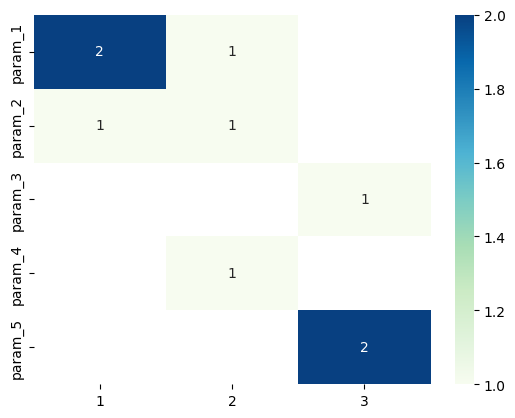

In [11]:
d1 = {"1": "param_1", "2": "param_2", "3": "param_3"}
d2 = {"1": "param_1", "2": "param_4", "3": "param_5"}
d3 = {"1": "param_2", "2": "param_1", "3": "param_5"}

df = pd.DataFrame([d1,d2,d3])

print(df)

counts = df.apply(pd.Series.value_counts)

print(counts)

sns.heatmap(counts, cmap="GnBu", annot=True)

In [2]:
a = [ 1, 2, 3]
b = [1, 2, 3, 4]
results  = [None] * len(a) * len(b)
results

[None, None, None, None, None, None, None, None, None, None, None, None]

In [4]:
model_name = "communicty/gooy2:23"


def treat_model_name_for_filename( model_name: str):
  """ separate from model name the / and : values.
      For instance from community/gpt2:xl we will take only gpt2.  """
  if model_name.__contains__("/"):
    model_name = model_name.replace("/", "-")
  if model_name.__contains__(":"):
    model_name = model_name.replace(":", "_")

  return model_name

print(treat_model_name_for_filename(model_name))

communicty-gooy2_23


In [ ]:
d1 = {"a": 1, "b": 2, "c": 44, "d": 551}
d2 = {"a": 4, "b": 31, "c": 66, "d": 666}

d1c = d1.copy()
d1c.pop("a")

d1c
d1c = d1.copy()
d1c.pop("b")


2

In [29]:
import time

st = time.time()
time.sleep(2)
et = time.time()
print("reportParamGridSearch time --- %s minutes ---" % ((et - st)/60))

reportParamGridSearch time --- 0.03334114551544189 minutes ---


In [27]:

 (et - st)/60

0.033339587847391765

In [23]:
default = {"a": 1, "b": 2, "c": 44, "d": 551}
param_dict = {"a": 4, "b": 31, "x": "a", "y": "b"}

set(param_dict) != set(default)


False

In [8]:
import pandas as pd

d1 = {"a": 1, "b": 2, "c": 44, "d": 551}
d2 = {"a": 4, "b": 31, "c": 66, "d": 666}


methods = ["A", "B"]
df = pd.DataFrame([d1,d2, d1, d2])

print(df)

for idx, row in df.iterrows():
  print(f"\nidx: {idx}")
  print(f"\nrow: {row}")

len(df)



   a   b   c    d
0  1   2  44  551
1  4  31  66  666
2  1   2  44  551
3  4  31  66  666

idx: 0

row: a      1
b      2
c     44
d    551
Name: 0, dtype: int64

idx: 1

row: a      4
b     31
c     66
d    666
Name: 1, dtype: int64

idx: 2

row: a      1
b      2
c     44
d    551
Name: 2, dtype: int64

idx: 3

row: a      4
b     31
c     66
d    666
Name: 3, dtype: int64


4

In [7]:
test = {method: idx for idx, row in df.iterrows() for method in methods }
print(test)

{'A': 3, 'B': 3}


In [ ]:
df.iloc[[0, 2]]

,a,b,c,d
0,1,2,44,551
2,1,2,44,551


In [ ]:
en = enumerate(d1)
for i in en:
  print(i)



(0, 'a')
(1, 'b')


In [ ]:
d3 = {"a": [1, 2, 3], "b": [4, 5, 6], "c": [9]}
key_list = [k for k in d3.keys()]
key_list

['a', 'b', 'c']

In [ ]:
from re import M
from itertools import product

d1 = {"a": [1, 2, 3]}
d2 = {"b": [4, 5, 6]}

d3 = {"a": [1, 2, 3], "b": [4, 5, 6], "c": [9]}

res_list = list(product(*d3.values()))

a = []

a.append({"a":33})



[{'a': 33}]

In [ ]:
"b" in d-

True

In [ ]:
def get_dict_comb(param_dict: dict):
  res_list = list(product(*d3.values()))
  key_list = [k for k in param_dict.keys()]
  combi_list = []
  tmp = {}

  for idx, param_list in enumerate(res_list):
    tmp = {k: v for k, v in zip(key_list, param_list)}
    combi_list.append(tmp)

  return combi_list

param_ls = get_dict_comb(d3)
param_ls

[{'a': 1, 'b': 4, 'c': 9},
 {'a': 1, 'b': 5, 'c': 9},
 {'a': 1, 'b': 6, 'c': 9},
 {'a': 2, 'b': 4, 'c': 9},
 {'a': 2, 'b': 5, 'c': 9},
 {'a': 2, 'b': 6, 'c': 9},
 {'a': 3, 'b': 4, 'c': 9},
 {'a': 3, 'b': 5, 'c': 9},
 {'a': 3, 'b': 6, 'c': 9}]